# Prototyping Settings for Simplistic DESC SRD Y1

For reference, the DESC SRD can be found [here](https://arxiv.org/pdf/1809.01669.pdf). Appendix D2 specifies some of the analysis choices for the Y1 data. 

In particular:
- neff for lensing sources: 10 gal/arcmin^2
- sigma_e: 0.26 per component
- lmax: 3000


In this notebook, we will try to find simulation settings that can get us close to these specifications, and use a kappa TNG map as a reference point.

## Defining FlowPM simulation

In [9]:
%pylab inline 

import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Below are a few parameters
n_lens = 22       # Number of lensplanes in the lightcone
box_size = 100.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel
z_source = np.array([1.]) # We'll be using a single redshift for now

In [11]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 10)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [12]:
#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [13]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 

In [181]:
# Extract the lensplanes
lensplanes = []

for i in range(len(a_center)):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=512,
                                            shift=flowpm.raytracing.random_2d_shift())
    
    plane = tf.expand_dims(plane, axis=-1)
    plane = tf.image.random_flip_left_right(plane)
    plane = tf.image.random_flip_up_down(plane)
    lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))

In [182]:
# Get convergence map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)


m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/512, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m = m.numpy().reshape([batch_size, field_npix, field_npix])

## Comparison to kappa TNG

For comparison, we are using this map at redshift 1 from the kappa TNG simulations.

In [183]:
import lenstools as lt
kTNG = lt.ConvergenceMap(np.load('kappa_tng.npy'), 5*u.deg)
kFPM = lt.ConvergenceMap(m[0], 5*u.deg)

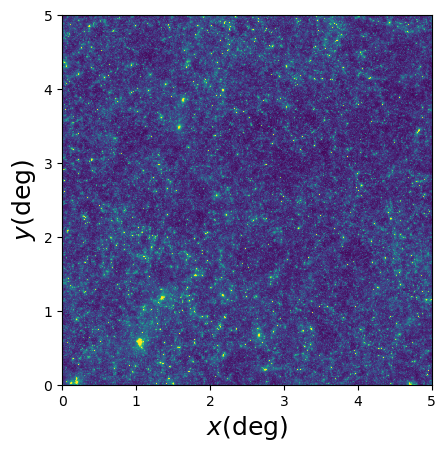

In [184]:
kTNG.visualize(vmax=0.15)

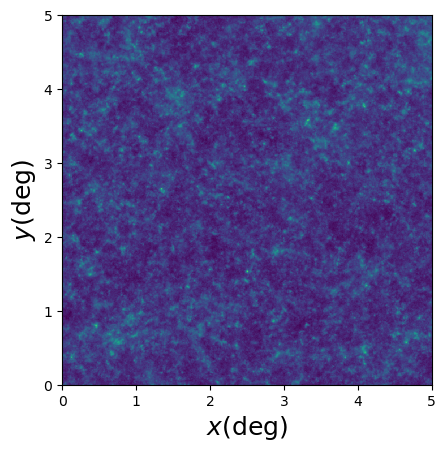

In [185]:
kFPM.visualize(vmax=0.15)

In [186]:
# Let's check power spectra
l_edges = np.logspace(2., 4, 16)
ps = kFPM.powerSpectrum(l_edges)[1]
l, psr = kTNG.powerSpectrum(l_edges)

Text(0.5, 1.0, 'Comparison to kappaTNG')

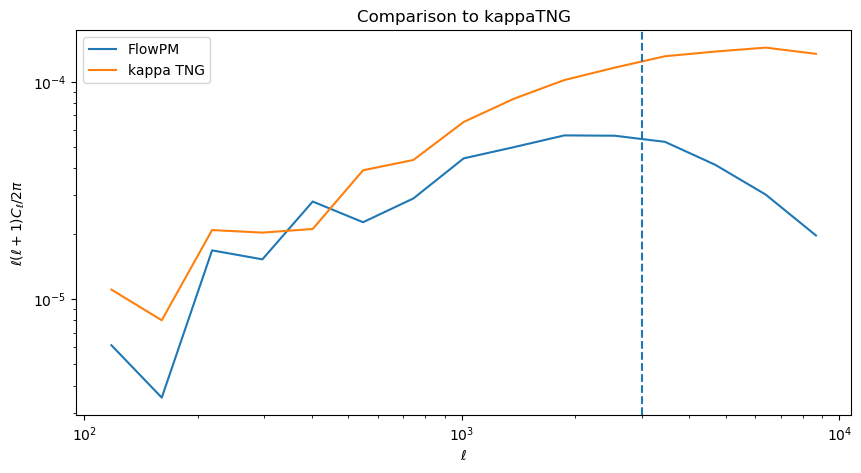

In [187]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps/(2*pi), label='FlowPM')
loglog(l, l*(l+1)*psr/(2*pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG')

In [188]:
# Let's also compare native peak counts
re,rh = kTNG.peakCount(linspace(-0.05,0.2,16))
te,th = kFPM.peakCount(linspace(-0.05,0.2,16))

Text(0.5, 0, '$\\kappa$')

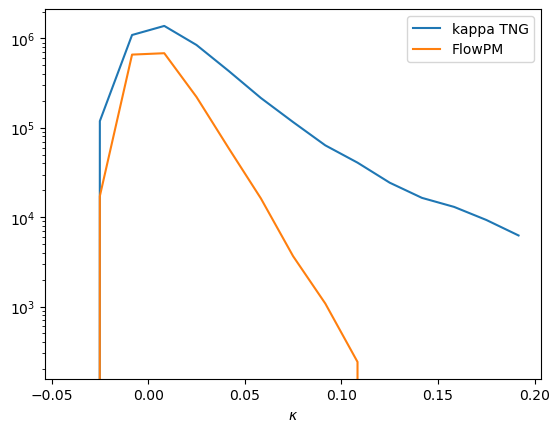

In [189]:
semilogy(re, rh, label='kappa TNG')
semilogy(te, th, label='FlowPM')
legend()
xlabel('$\kappa$')

So, obvioulsy our 128^3 simulation is not as precise as kappa TNG, but we won't be working at the native 0.3 arcmin resolution anyway, in practice we'll have noise and smoothing.

So let's see how much smoothing gets us in the right ball park.

In [190]:
import astropy.units as u
smoothing = 1.*u.arcmin

(-0.5, 1023.5, 1023.5, -0.5)

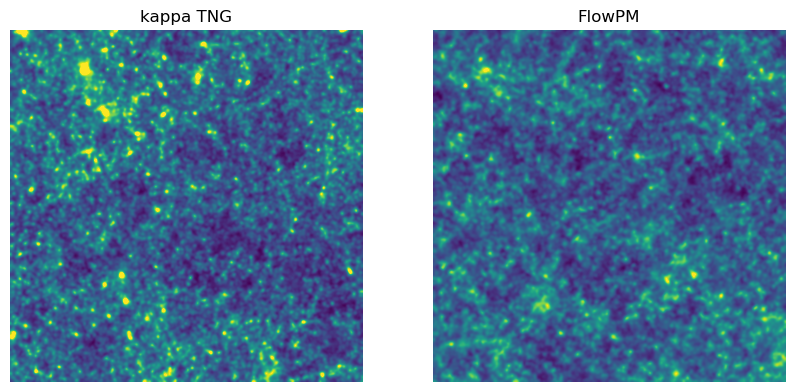

In [191]:
figure(figsize=[10,20])
subplot(121)
title('kappa TNG')
imshow(kTNG.smooth(smoothing).data, vmax=0.05)
axis('off')
subplot(122)
title('FlowPM')
imshow(kFPM.smooth(smoothing).data, vmax=0.05)
axis('off')

In [192]:
# Let's check power spectra
l_edges = np.logspace(2., 4, 16)
ps = kFPM.smooth(smoothing).powerSpectrum(l_edges)[1]
l, psr = kTNG.smooth(smoothing).powerSpectrum(l_edges)

Text(0.5, 1.0, 'Comparison to kappaTNG')

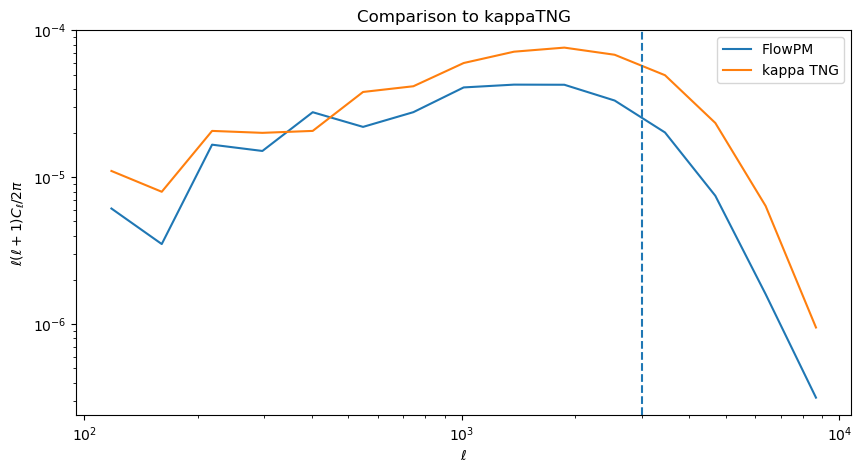

In [193]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps/(2*pi), label='FlowPM')
loglog(l, l*(l+1)*psr/(2*pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG')

In [194]:
# Let's also compare native peak counts
re,rh = kTNG.smooth(smoothing).peakCount(linspace(-0.02,0.04,16))
te,th = kFPM.smooth(smoothing).peakCount(linspace(-0.02,0.04,16))

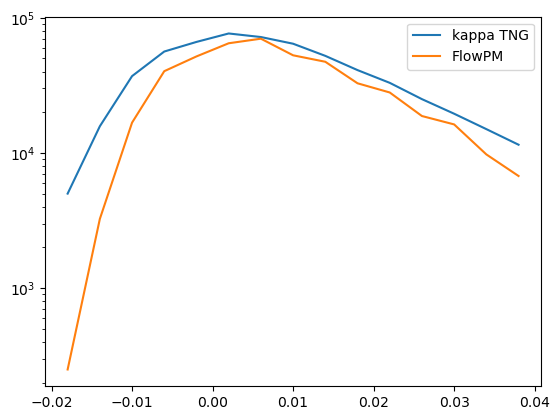

In [195]:
semilogy(re, rh, label='kappa TNG')
semilogy(te, th, label='FlowPM')
legend()

Humm not perfect, but not crazy either all things considered.

## Adding noise

We'll now try to get to a realistic setting that matches some of the SRD Y1 settings.

In [196]:
ngal = 10                          # gal/arcmin **2
pix_scale = 5/1024*60              # arcmin
ngal_per_pix = ngal * pix_scale**2 # galaxies per pixels (I think)
sigma_e = 0.26 / sqrt(2 * ngal_per_pix) # Rescaled noise sigma

In [197]:
knTNG = lt.ConvergenceMap(np.load('kappa_tng.npy') 
                          + sigma_e * randn(1024,1024), 5*u.deg)
knFPM = lt.ConvergenceMap(m[0]+ sigma_e * randn(1024,1024), 5*u.deg)

(-0.5, 1023.5, 1023.5, -0.5)

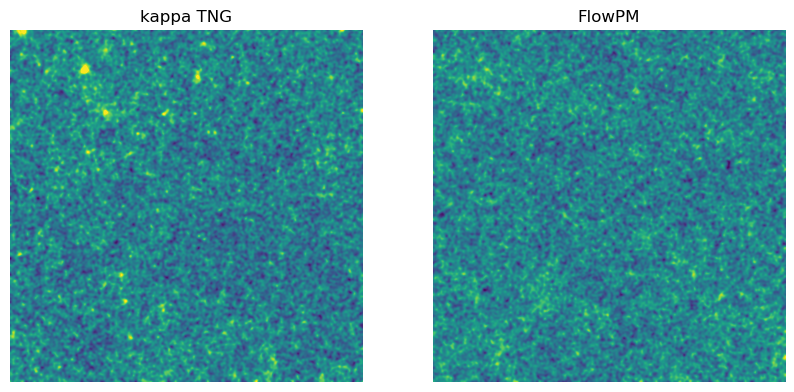

In [198]:
# Here is what it looks like with noise 
figure(figsize=[10,20])
subplot(121)
title('kappa TNG')
imshow(knTNG.smooth(smoothing).data, vmax=0.1)
axis('off')
subplot(122)
title('FlowPM')
imshow(knFPM.smooth(smoothing).data, vmax=0.1)
axis('off')

In [199]:
# Let's check power spectra
l_edges = np.logspace(2., 4, 16)
ps = knFPM.smooth(smoothing).powerSpectrum(l_edges)[1]
l, psr = knTNG.smooth(smoothing).powerSpectrum(l_edges)

Text(0.5, 1.0, 'Comparison to kappaTNG')

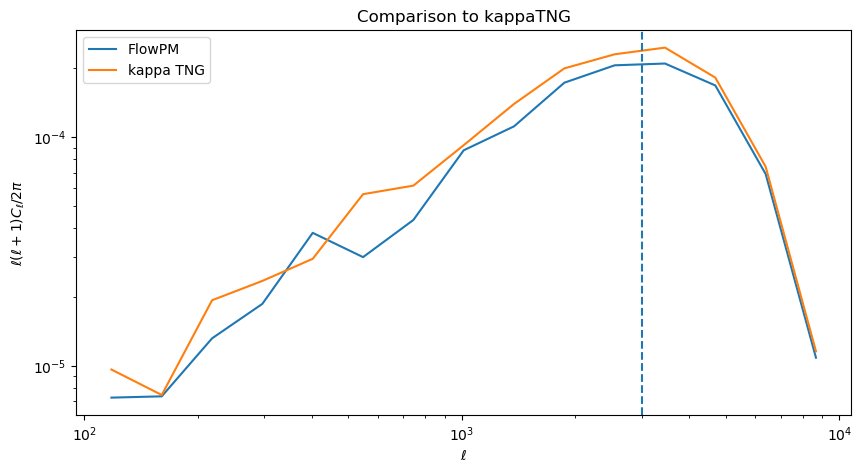

In [200]:
figure(figsize=[10,5])
loglog(l, l*(l+1)*ps/(2*pi), label='FlowPM')
loglog(l, l*(l+1)*psr/(2*pi), label='kappa TNG')
legend()
axvline(3000, ls='--')
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
title('Comparison to kappaTNG')

In [201]:
# Let's also compare native peak counts
re,rh = knTNG.smooth(smoothing).peakCount(linspace(-0.025,0.1,16))
te,th = knFPM.smooth(smoothing).peakCount(linspace(-0.025,0.1,16))

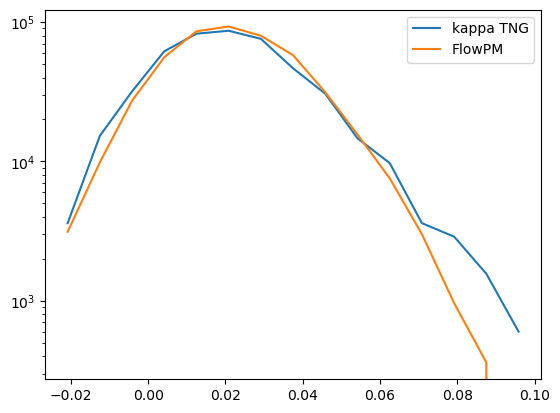

In [202]:
semilogy(re, rh, label='kappa TNG')
semilogy(te, th, label='FlowPM')
legend()